# AMOC variability in FOCI-OpenIFS

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cmocean 
from scipy.signal import welch
import datetime as dt
import cftime 
import seaborn as sns

In [69]:
sns.set(font_scale = 1.5)
sns.set_style("whitegrid")
sns.set_style("ticks")

In [2]:
from dask.distributed import Client, LocalCluster, wait

In [3]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34141 instead
  expected, actual


In [4]:
client

Client Scheduler: tcp://127.0.0.1:45593 Dashboard: http://127.0.0.1:34141/status,Cluster Workers: 4 Cores: 8 Memory: 59.60 GiB


In [5]:
machine = 'nesh'

if machine == 'sci':
    esmdir = '/data/user/jkjellsson/esm-experiments/focioifs/'
    nemo_mesh = '/data/user/jkjellsson/orca05_mesh_mask.nc'
elif machine == 'nesh':
    esmdir = '/gxfs_work1/geomar/smomw352/esm-experiments/'
    nemo_mesh = '/gxfs_work1/geomar/smomw352/orca05_mesh_mask.nc'

## Read NEMO mesh

In [6]:
# NEMO mesh
ds_mesh = xr.open_dataset(nemo_mesh)
da_orca05_area = (ds_mesh['e1t'] * ds_mesh['e2t']).sel(t=0)
da_orca05_mask = ds_mesh['tmask'].sel(t=0,z=0)

## Read NEMO stream functions

In [7]:
exp_list = ['FOCI_GJK001']

In [8]:
# NEMO derived
ds_moc_all = []
ds_psi_all = []
for exp in exp_list:
    moc = '/%s/%s/outdata/nemo/cdf_analysis/%s*1m*MOC.nc' % (esmdir,exp,exp)
    print(moc)
    ds_moc = xr.open_mfdataset(moc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'})
    ds_moc_all.append(ds_moc)
    
    psi = '/%s/%s/outdata/nemo/cdf_analysis/%s*1m*PSI.nc' % (esmdir,exp,exp)
    print(psi)
    ds_psi = xr.open_mfdataset(psi,combine='by_coords',use_cftime=True).rename({'time_counter':'time'})
    ds_psi_all.append(ds_psi)

//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1m*MOC.nc
//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1m*PSI.nc


## Detrend

In [25]:
def detrend(da, dim='time'):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=1)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

## Time-mean overturning

<xarray.Dataset>
Dimensions:    (depthw: 46, time: 12360, x: 1, y: 511)
Coordinates:
  * depthw     (depthw) float32 -0.0 -6.194 -12.84 ... -5.5e+03 -5.75e+03
  * time       (time) object 1850-01-16 12:00:00 ... 2879-12-16 12:00:00
Dimensions without coordinates: x, y
Data variables:
    nav_lon    (time, y, x) float32 dask.array<chunksize=(120, 511, 1), meta=np.ndarray>
    nav_lat    (time, y, x) float32 dask.array<chunksize=(120, 511, 1), meta=np.ndarray>
    zomsfglo   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfatl   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfinp   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfind   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfpac   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfinp0  (time, depthw, y,

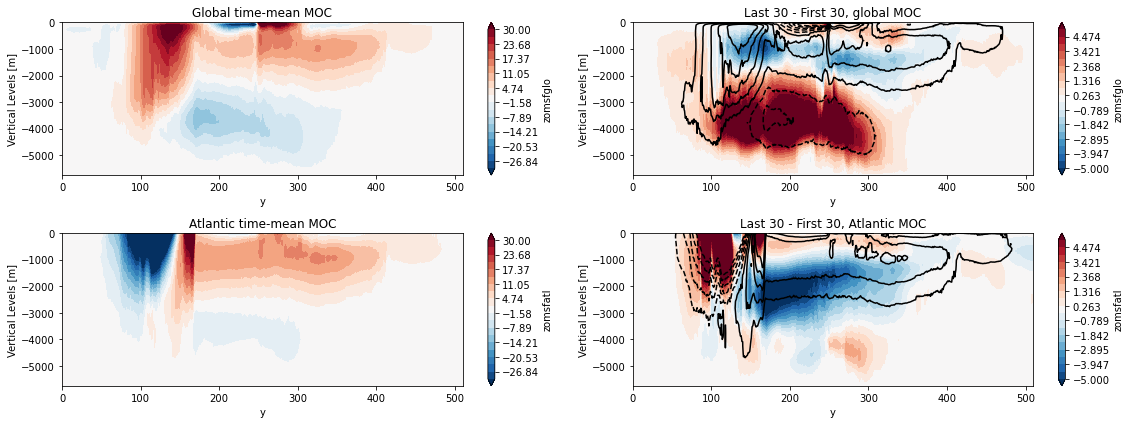

In [19]:
fig, ax = plt.subplots(2,2,figsize=(16,6))

mlevels = np.linspace(-30,30,20)
mlevels2 = np.linspace(-5,5,20)

for i in range(0,len(exp_list)):
    ds_moc = ds_moc_all[i]
    print(ds_moc)
    
    glo = ds_moc['zomsfglo'].sel(x=0)
    atl = ds_moc['zomsfatl'].sel(x=0)
    
    glo_mean = glo.mean('time')
    atl_mean = atl.mean('time')
    
    # Compare first and last 30 years
    glo_diff = glo[-360:,:,:].mean('time') - glo[0:360,:,:].mean('time')
    atl_diff = atl[-360:,:,:].mean('time') - atl[0:360,:,:].mean('time')
    
    glo_mean.plot.contourf(ax=ax[0,0],levels=mlevels)
    glo_mean.plot.contour(ax=ax[0,1],levels=mlevels[::2],colors='k')
    glo_diff.plot.contourf(ax=ax[0,1],levels=mlevels2)
    ax[0,0].set_title('Global time-mean MOC')
    ax[0,1].set_title('Last 30 - First 30, global MOC')
    
    atl_mean.plot.contourf(ax=ax[1,0],levels=mlevels)
    atl_mean.plot.contour(ax=ax[1,1],levels=mlevels[::2],colors='k')
    atl_diff.plot.contourf(ax=ax[1,1],levels=mlevels2)
    ax[1,0].set_title('Atlantic time-mean MOC')
    ax[1,1].set_title('Last 30 - First 30, Atlantic MOC')

fig.tight_layout()
fig.savefig('moc.jpg',format='jpg',dpi=600)

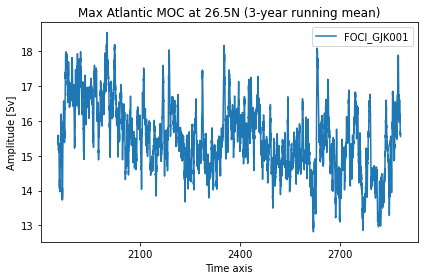

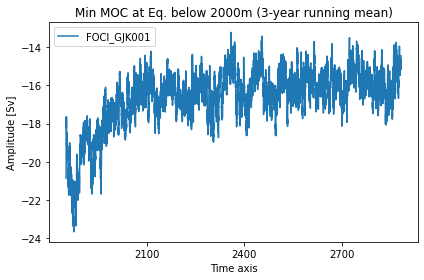

In [20]:
fig1, ax1 = plt.subplots(1,1)
fig2, ax2 = plt.subplots(1,1)

for i in range(0,len(exp_list)):
    exp = exp_list[i]
    ds_moc = ds_moc_all[i]
    
    # Max stream function at y=304 (26.5 N)
    amoc = ds_moc['zomsfatl'].sel(x=0,y=304).max('depthw').compute()
    amoc.rolling(time=36).mean().plot(ax=ax1,label=exp)
    
    # Min stream function at y=250 (approx equator) below 2000
    aabw = ds_moc['zomsfglo'][:,29:,:,:].sel(x=0,y=250).min('depthw').compute()
    aabw.rolling(time=36).mean().plot(ax=ax2,label=exp)
    
ax1.set_title('Max Atlantic MOC at 26.5N (3-year running mean)')
ax1.set_ylabel('Amplitude [Sv]')
ax1.legend()
fig1.tight_layout()
fig1.savefig('moc_timeseries.png',format='png')

ax2.set_title('Min MOC at Eq. below 2000m (3-year running mean)')
ax2.set_ylabel('Amplitude [Sv]')
ax2.legend()
fig2.tight_layout()
fig2.savefig('aabw_timeseries.png',format='png')

## Power spectrum of AMOC

In [21]:
def powerspectrum(x, fs=1):
    # sample size
    N = x.size
    
    # bandwidth
    df = fs / N
    
    # frequency of the signal [cycle-per-time-unit]
    f_0 = 1. / 1.
    
    # length of time series
    t1 = N / fs
    
    # length of sample in cycles
    n_cycle = N / fs * f_0
    
    t = np.linspace(0., t1, N)
    freq = np.fft.rfftfreq(N,1./fs)
    
    #omega_nino = 2 * np.pi * freq
    f_transform = np.fft.rfft(x)   # [units]
    amp = np.abs(f_transform) / N  # [units]
    Phi = amp ** 2                 # [units**2]
    PSD = Phi / df                 # [units**2 / fs time]
    
    return freq,PSD

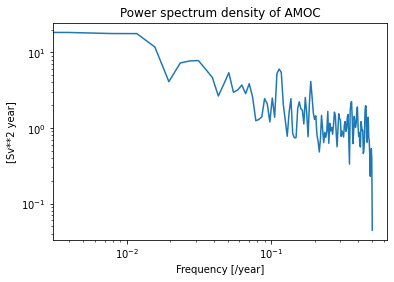

In [29]:
# Use only from year 250 onward due to spin up
times = slice('2100-01-01','2890-01-01')
amoc_raw = amoc.sel(time=times)

# Detrend data (linear) to remove any drift
amoc_detrend = detrend( amoc_raw, dim='time' )
x = amoc_detrend.groupby('time.year').mean('time').values

# Use Welch method to reduce noise
freq, PSD = welch(x,fs=1)

fig1, ax1 = plt.subplots(1,1)
ax1.loglog(freq,PSD)
ax1.set_xlabel('Frequency [/year]');
ax1.set_ylabel('[Sv**2 year]');
ax1.set_title('Power spectrum density of AMOC');
#ax1.set_ylim([1e-3,1e3])
fig1.savefig('figures/Fig_AMOC_PSD.pdf',format='pdf')

## Make one plot for AMOC and ACC

j index: 349, AMOC latitude: 45.081944 
 Compute AMOC strf


/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: The following kwargs were not used by contour: 'rasterized'


 Compute AMOC time series 
 Compute baro psi 


/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: The following kwargs were not used by contour: 'rasterized'


 Compute Drake Pass 


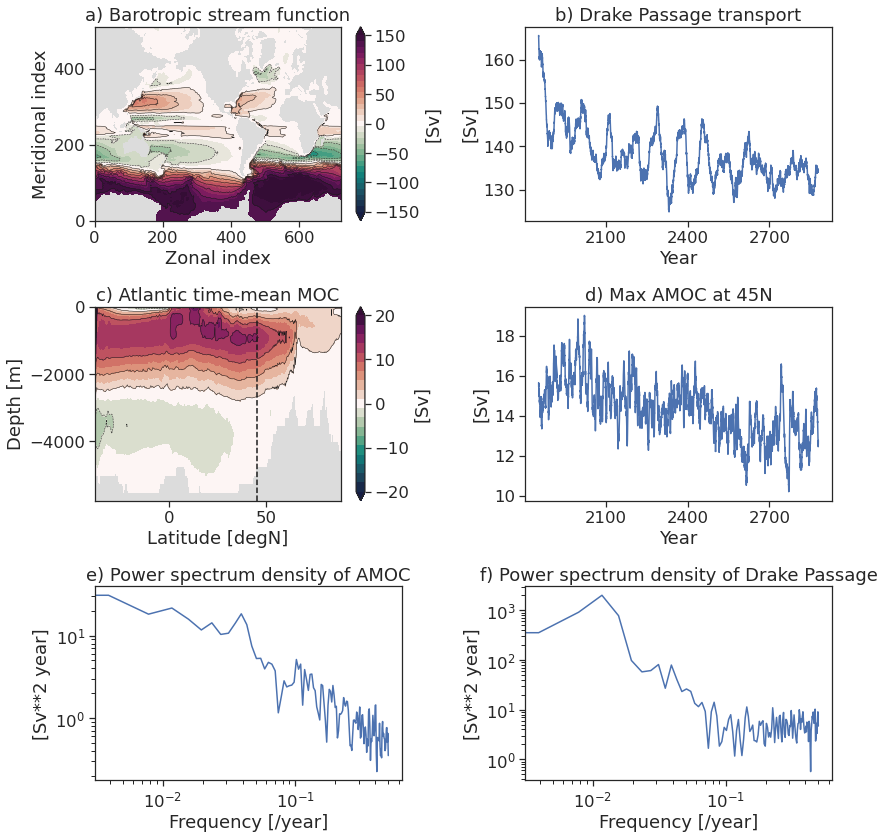

In [72]:
bg_color = 'Gainsboro'

# Only use from year 250 onward
times = slice('2100-01-01','2890-01-01')

# Which latitude to use for AMOC index
amoc_lat = 45
nav_lat = ds_moc_all[0]['nav_lat'][0,:,0].values
# Find j index closest to amoc_lat
amoc_j = np.argmin( np.abs(nav_lat - amoc_lat) )
print('j index: %d, AMOC latitude: %f ' % (amoc_j, nav_lat[amoc_j]))

fig, ax = plt.subplots(3,2,figsize=(12,12))

for i, (ds_moc,ds_psi) in enumerate( zip(ds_moc_all, ds_psi_all) ):
    
    atl = ds_moc['zomsfatl'].sel(time=times).sel(x=0)
    print(' Compute AMOC strf')
    atl_mean = atl.mean('time').compute()
    
    mlevels = np.linspace(-20,20,20)
    #cbar_kwargs = {'label':'Sv', 'ticks':[-20,-10,0,10,20]}
    #atl_mean.where(atl_mean != 0).plot.contourf(ax=ax[1,0],levels=mlevels, cbar_kwargs=cbar_kwargs, rasterized=True)
    #atl_mean.where(atl_mean != 0).plot.contour(ax=ax[1,0],levels=mlevels[::2],colors='k', linewidths=0.5, rasterized=True)
    dep = atl_mean['depthw'].values
    z = atl_mean.where(atl_mean != 0).values
    cf = ax[1,0].contourf(nav_lat, dep, z, levels=mlevels, extend='both', cmap=cmocean.cm.curl, rasterized=True)
    ct = ax[1,0].contour(nav_lat, dep, z, levels=mlevels[::2], colors='k', linewidths=0.5)
    cb = plt.colorbar(cf, ax=ax[1,0])
    cb.set_label('[Sv]')
    cb.set_ticks([-20,-10,0,10,20])
    ax[1,0].set_title('c) Atlantic time-mean MOC')
    #ax[1,0].set_xlim([176,510])
    ax[1,0].set_xlim([-38,88])
    ax[1,0].set_xlabel('Latitude [degN]')
    ax[1,0].set_ylabel('Depth [m]')
    ax[1,0].axvline(x=nav_lat[amoc_j], linestyle='--', c='k')
    ax[1,0].set_facecolor(bg_color)
    
    # Max stream function 
    print(' Compute AMOC time series ')
    amoc = ds_moc['zomsfatl'].sel(x=0,y=amoc_j).max('depthw').compute()
    amoc.rolling(time=36).mean().plot(ax=ax[1,1],label=exp)
    ax[1,1].set_title('d) Max AMOC at %dN' % (amoc_lat,))
    ax[1,1].set_xlabel('Year')
    ax[1,1].set_ylabel('[Sv]')
    
    # Compute annual means of AMOC
    x = amoc.groupby('time.year').mean('time')
    # Detrend
    x_det = detrend(x, dim='year')
    # Compute PSD with Welch method
    freq, PSD = welch(x_det, fs=1)
    ax[2,0].loglog(freq,PSD)
    ax[2,0].set_xlabel('Frequency [/year]');
    ax[2,0].set_ylabel('[Sv**2 year]');
    ax[2,0].set_title('e) Power spectrum density of AMOC');
    
    # Take barotropic stream function
    psi = ds_psi['sobarstf'] * 1e-6
    print(' Compute baro psi ')
    psi_mean = psi.sel(time=times).mean('time').compute()
    psi_mean = psi_mean.where(da_orca05_mask == 1)
    
    #mlevels = np.linspace(-50,150,20)
    mlevels = np.linspace(-150,150,32)
    #cbar_kwargs = {'label':'Sv', 'ticks':[-50,0,50,100,150]}
    #psi_mean.plot.contourf(ax=ax[0,0],levels=mlevels, cbar_kwargs=cbar_kwargs, extend='both',rasterized=True)
    #psi_mean.plot.contour(ax=ax[0,0],levels=mlevels[::2],colors='k', linewidths=0.5, rasterized=True)
    x = psi_mean['x']
    y = psi_mean['y']
    z = psi_mean.values
    cf = ax[0,0].contourf(x, y, z, levels=mlevels, cmap=cmocean.cm.curl, extend='both',rasterized=True)
    ct = ax[0,0].contour(x, y, z, levels=mlevels[::2], colors='k', linewidths=0.5)
    cb = plt.colorbar(cf, ax=ax[0,0])
    cb.set_label('[Sv]')
    cb.set_ticks([-150,-100,-50,0,50,100,150])
    ax[0,0].set_title('a) Barotropic stream function')
    ax[0,0].set_facecolor(bg_color)
    ax[0,0].set_xlabel('Zonal index')
    ax[0,0].set_ylabel('Meridional index')
    
    # Drake Passage
    print(' Compute Drake Pass ')
    drake = (psi.sel(x=436,y=51) - psi.sel(x=436,y=119)).compute()
    drake.rolling(time=36).mean().plot(ax=ax[0,1],label=exp)
    ax[0,1].set_title('b) Drake Passage transport')
    ax[0,1].set_xlabel('Year')
    ax[0,1].set_ylabel('[Sv]')
    
    # Select from 2100 onward and compute annual means
    x = drake.sel(time=times).groupby('time.year').mean('time')
    # Detrend 
    x_det = detrend(x, dim='year')
    # Compute PSD using Welch method
    freq, PSD = welch(x_det.values, fs=1)
    ax[2,1].loglog(freq,PSD)
    ax[2,1].set_xlabel('Frequency [/year]');
    ax[2,1].set_ylabel('[Sv**2 year]');
    ax[2,1].set_title('f) Power spectrum density of Drake Passage');
    
fig.tight_layout()
fig.savefig('figures/Fig_strf.pdf',format='pdf')

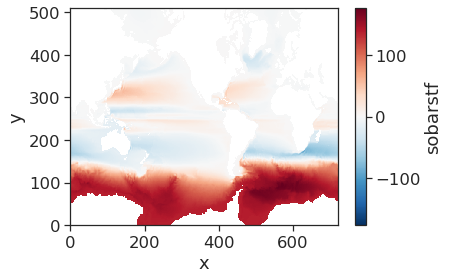

In [70]:
psi_mean.plot()